# LDA Topic Analysis

In this notebook, we outline the process of training a Latent Dirichlet Allocation (LDA) model using a preprocessed dataset from the White House and European Commission communications. It is divided in three parts:

First, we find the right parameters for our analysis. We experiment with different parameters  count vectorization, TF-IDF, and the LDA model itself to determine the most effective settings.

Second, we identify to which extent each dataset (White House and European Commission) contributes to each topic and the timeline of the topics on the joint dataset.

Thirdly, we extract the weekly contribution to each topic for each dataset

# Structure of the notebook

0. Import functions and loading the dataset

1. Selecting Optimal Min_DF and Max_DF Parameters for LDA Topic Analysis

2. Training the LDA model

3. Understanding the contribution of which dataset to each topic and the time-trends on the Joint Dataset

4. Weekly contribution to each topic of each dataset

5. Appendix

# 0. Import functions and loading the dataset

In [13]:
import pandas as pd
import numpy as np
import csv

import spacy
sp = spacy.load('en_core_web_sm')

from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import os

from gensim.corpora.dictionary import Dictionary
from gensim import models
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from gensim.matutils import Sparse2Corpus

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from gensim.matutils import Sparse2Corpus
from gensim.corpora import Dictionary
from gensim import models

import matplotlib.pyplot as plt



In [14]:
path="/Users/ruimaciel/Desktop/Barcelona/NLP_I/NLP-Project/"
filename_EC ="data/theeuropeancommission_preprocessed.csv"
EC_data = pd.read_csv(os.path.join(path, filename_EC), sep=',', encoding='utf-8')
#Checking everything is fine
EC_data.head(5)

,Title,Date,Category,Text,text_preproc,titles_preproc,Ukraine
0,European Commission authorises second safe and...,2021-01-06,Press Release,"Today, the European Commission has granted a c...",today european commission grant conditional ma...,european commission authorise second safe effe...,0
1,Statement by President von der Leyen on the re...,2021-01-07,Statement,What happened in Washington yesterday is as ...,happen washington yesterday appalling outrageo...,statement president von der leyen recent devel...,0
2,Commission proposes to purchase up to 300 mill...,2021-01-08,Press Release,The European Commission today proposed to the ...,european commission today propose EU member st...,commission propose purchase 300 million additi...,0
3,Speech by President von der Leyen at the One P...,2021-01-11,Speech,"Merci Monsieur le Président.\nCher Emmanuel,\n...",merci monsieur le président cher emmanuel deli...,speech president von der leyen one planet summit,0
4,Coronavirus: Commission concludes exploratory ...,2021-01-12,Press Release,"Today, the European Commission concluded explo...",today european commission conclude exploratory...,coronavirus commission conclude exploratory ta...,0


In [15]:
filename ="data/thewhitehouse_preprocessed.csv"
WH_data= pd.read_csv(os.path.join(path, filename), sep=',', encoding='utf-8')
#Checking everything is fine
WH_data.head(5)

,Title,Date,Category,Text,text_preproc,titles_preproc,Ukraine
0,"Press Briefing by Press Secretary Jen Psaki, J...",2021-01-20,Press Release,James S. Brady Press Briefing Room\n\n7:06 P.M...,706 PM est good evening everyone thank join hi...,press briefing press secretary jen psaki janua...,0
1,Fact Sheet: President Biden Sends Immigration ...,2021-01-20,Statement,The U.S. Citizenship Act of 2021 establishes a...,US citizenship act 2021 establish new system r...,fact sheet president biden sends immigration b...,0
2,President Joe Biden Announces Acting Federal A...,2021-01-20,Statement,"WASHINGTON – Today, President Joe Biden announ...",WASHINGTON today president joe biden announce ...,president joe biden announces acting federal a...,0
3,"Press Briefing by Press Secretary Jen Psaki, J...",2021-01-21,Press Release,James S. Brady Press Briefing Room\n\n4:03 P.M...,403 PM est good afternoon thank join today man...,press briefing press secretary jen psaki janua...,0
4,Fact Sheet: President Biden’s New Executive Ac...,2021-01-22,Statement,The COVID-19 pandemic has forced the United St...,covid19 pandemic force united states economy e...,fact sheet president biden new executive actio...,0


In [16]:
#Create a column named "European Commission" with the value 1
EC_data['is_EC'] = 1
#Create a column named
WH_data['is_EC'] = 0
joint_data=pd.concat([EC_data, WH_data], ignore_index=True)
joint_data

,Title,Date,Category,Text,text_preproc,titles_preproc,Ukraine,is_EC
0,European Commission authorises second safe and...,2021-01-06,Press Release,"Today, the European Commission has granted a c...",today european commission grant conditional ma...,european commission authorise second safe effe...,0,1
1,Statement by President von der Leyen on the re...,2021-01-07,Statement,What happened in Washington yesterday is as ...,happen washington yesterday appalling outrageo...,statement president von der leyen recent devel...,0,1
2,Commission proposes to purchase up to 300 mill...,2021-01-08,Press Release,The European Commission today proposed to the ...,european commission today propose EU member st...,commission propose purchase 300 million additi...,0,1
3,Speech by President von der Leyen at the One P...,2021-01-11,Speech,"Merci Monsieur le Président.\nCher Emmanuel,\n...",merci monsieur le président cher emmanuel deli...,speech president von der leyen one planet summit,0,1
4,Coronavirus: Commission concludes exploratory ...,2021-01-12,Press Release,"Today, the European Commission concluded explo...",today european commission conclude exploratory...,coronavirus commission conclude exploratory ta...,0,1
...,...,...,...,...,...,...,...,...
4928,Readout of President Biden’s Call with Amir Sh...,2023-12-26,Statement,"President Joseph R. Biden, Jr. spoke today wit...",president joseph r biden jr speak today amir s...,readout president biden call amir sheikh tamim...,0,0
4929,Statement from President Joe Biden on the Pass...,2023-12-28,Statement,Herb Kohl was one of the finest people I’ve se...,herb kohl one fine people serve kind principle...,statement president joe biden passing former U...,0,0
4930,Statement from President Joe Biden on Judy Wei...,2023-12-28,Statement,Jill and I are devastated to learn that Americ...,jill devastate learn american judy weinstein a...,statement president joe biden judy weinstein,0,0
4931,Statement from President Joe Biden on Russia’s...,2023-12-29,Statement,"Overnight, Russia launched its largest aerial ...",overnight russia launch large aerial assault u...,statement president joe biden russia aerial as...,1,0


# 1. Selecting Optimal Min_DF and Max_DF Parameters for LDA Topic Analysis

In [17]:

def analyze_text_data(data, min_df, max_df):
    # Previous setup for CountVectorizer and TfidfVectorizer
    
    # Initialize CountVectorizer with specified parameters
    cv = CountVectorizer(ngram_range=(1,2), lowercase=True, min_df=min_df, max_df=max_df, stop_words='english')
    
    # Fit CountVectorizer and transform text and title data
    cv.fit(data.text_preproc)
    vectorized_text = cv.transform(data.text_preproc).toarray()
    vectorized_title = cv.transform(data.titles_preproc).toarray()
    vectorized_text_title_weight = 2 * vectorized_title + vectorized_text
    
    # Apply SVD to CountVectorizer output
    svd = TruncatedSVD(n_components=10)
    U = svd.fit_transform(vectorized_text_title_weight)
    VT = svd.components_
    
    # Initialize TfidfVectorizer with specified parameters
    tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=min_df, max_df=max_df)
    
    # Fit and transform text data using TfidfVectorizer
    tfidf.fit(data.text_preproc)  # Adjusted to fit the correct dataset
    tfidf_matrix_text = tfidf.transform(data.text_preproc)
    tfidf_matrix_title = tfidf.transform(data.titles_preproc)
    
    # Perform SVD on TF-IDF matrices
    svd_tfidf = TruncatedSVD(n_components=10)
    U_text = svd_tfidf.fit_transform(tfidf_matrix_text)
    U_title = svd_tfidf.transform(tfidf_matrix_title)
    
    # LDA Analysis
    dtm = 2 * vectorized_title + vectorized_text  # Reuse weighted document-term matrix
    dtm_sparse = csr_matrix(dtm)  # Convert to sparse format for gensim
    corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)  # Convert to gensim corpus
    dictionary = Dictionary.from_corpus(corpus, id2word=dict((id, word) for word, id in cv.vocabulary_.items()))
    
    # Build LDA model
    lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=10, random_state=10)
    
    # Collect top words for LDA
    lda_output = "Top words associated with each topic (LDA):\n"
    topics = lda_model.show_topics(num_words=10, formatted=False)
    for topic_num, topic_words in topics:
        words = ', '.join([word for word, _ in topic_words])
        lda_output += f"Topic {topic_num + 1}: {words}\n"

    # Collect outputs for Count Vectorization and TF-IDF Vectorization
    count_vectorization_output = ""
    tfidf_vectorization_output = ""
    
    # Collect top words for Count Vectorization
    count_vectorization_output += "Top words associated with each topic (Count Vectorization):\n"
    feature_names_count = cv.get_feature_names_out()
    for topic_idx, topic in enumerate(VT):
        top_words_idx = topic.argsort()[::-1][:10]  # Get indices of top 10 words
        top_words = [feature_names_count[i] for i in top_words_idx]
        count_vectorization_output += f"Topic {topic_idx+1}: {', '.join(top_words)}\n"
    
    # Collect top words for TF-IDF Vectorization
    tfidf_vectorization_output += "\nTop words associated with each topic (TF-IDF Vectorization):\n"
    feature_names_tfidf = tfidf.get_feature_names_out()
    for topic_idx, topic in enumerate(svd_tfidf.components_):
        top_words_idx = topic.argsort()[::-1][:10]  # Get indices of top 10 words
        top_words = [feature_names_tfidf[i] for i in top_words_idx]
        tfidf_vectorization_output += f"Topic {topic_idx+1}: {', '.join(top_words)}\n"    
    
    # Return all the collected outputs
    return count_vectorization_output, tfidf_vectorization_output, lda_output

In [18]:
def run_and_log_analyses(min_df_values, max_df_values, datasets, output_file_name):
    with open(output_file_name, "w") as file:
        for dataset_name, data in datasets.items():
            file.write(f"Analyzing dataset: {dataset_name}\n\n")
            for min_df in min_df_values:
                for max_df in max_df_values:
                    # Call analyze_text_data and unpack the returned outputs
                    count_vectorization_output, tfidf_vectorization_output, lda_output = analyze_text_data(data, min_df, max_df)
                    
                    file.write(f"min_df: {min_df}, max_df: {max_df}\n")
                    file.write(count_vectorization_output + "\n")
                    file.write(tfidf_vectorization_output + "\n")
                    file.write(lda_output + "\n\n")
            file.write("\n")  # Separator between datasets
    print(f"Analysis completed. Output written to {output_file_name}")


    

In [19]:
min_df_values = [0.005, 0.01, 0.05, 0.1]
max_df_values = [0.2, 0.3]

min_df_values_2 = [0.005, 0.01, 0.05, 0.1]
max_df_values_2 = [0.4, 0.5, 0.6]

datasets = {
    "joint_data": joint_data
}

run_and_log_analyses(min_df_values, max_df_values, datasets, "topics_analysis_output/analysis_output.txt")


Analysis completed. Output written to topics_analysis_output/analysis_output.txt


In [20]:
run_and_log_analyses(min_df_values_2, max_df_values_2, datasets, "topics_analysis_output/analysis_output_2.txt")


Analysis completed. Output written to topics_analysis_output/analysis_output_2.txt


# 2. Training the LDA model

In [90]:
def analyze_text_with_lda(data, min_df, max_df):
    # Initialize CountVectorizer
    cv = CountVectorizer(ngram_range=(1, 2), lowercase=False, min_df=min_df, max_df=max_df)
    
    # Fit CountVectorizer and transform text data
    cv.fit(data.text_preproc)
    vectorized_text = cv.transform(data.text_preproc).toarray()
    vectorized_title = cv.transform(data.titles_preproc).toarray()

    # Combine text and title vectorized data with specified weight
    dtm = 2 * vectorized_title + vectorized_text

    # Convert the combined DTM to a sparse format for gensim
    dtm_sparse = csr_matrix(dtm)

    # Convert sparse matrix to gensim corpus
    corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)

    # Create a Gensim dictionary from the CountVectorizer vocabulary
    dictionary = Dictionary()
    cv_vocabulary = {id_: token for token, id_ in cv.vocabulary_.items()}
    # Manually populate the Dictionary object
    dictionary.id2token = cv_vocabulary
    dictionary.token2id = {token: id_ for id_, token in cv_vocabulary.items()}

    # Hardcoded parameters for LDA
    num_topics = 10
    passes = 10
    random_state = 10

    # Build LDA model
    lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes, random_state=random_state)

    # Display the topics
    print("Top words associated with each topic (LDA):")
    topics = lda_model.show_topics(num_words=10, formatted=False)
    for topic_num, topic_words in topics:
        words = ', '.join([word for word, _ in topic_words])
        print(f"Topic {topic_num + 1}: {words}")

    return lda_model, corpus, cv



In [91]:
#We choose one lda and then role it, this is for text purposes
lda_model_joint, corpus_joint, cv = analyze_text_with_lda(joint_data, 0.05, 0.5)

Top words associated with each topic (LDA):
Topic 1: pay, cost, price, look, think, cut, economy, inflation, job, percent
Topic 2: would, ahead, want, talk, look, question, think, house, go ahead, speak
Topic 3: european, EU, europe, commission, plan, union, energy, member, der, von
Topic 4: applause, think, laughter, america, nation, want, look, every, never, day
Topic 5: administration, health, community, care, president biden, family, statement, program, million, act
Topic 6: climate, global, energy, partnership, investment, economic, technology, development, security, clean
Topic 7: vaccine, vaccinate, question, health, million, day, week, vaccination, test, community
Topic 8: ukraine, think, russia, security, president biden, US, israel, call, minister, question
Topic 9: job, america, infrastructure, investment, build, worker, billion, invest, clean, create
Topic 10: serve, university, member, US, national, director, law, board, nominee, department


# 3. Understanding the contribution of which dataset to each topic and the time-trends on the Joint Dataset

In [92]:
joint_data

,Title,Date,Category,Text,text_preproc,titles_preproc,Ukraine,is_EC,topic_0,topic_1,...,words_topic_1,words_topic_2,words_topic_3,words_topic_4,words_topic_5,words_topic_6,words_topic_7,words_topic_8,words_topic_9,year_month
0,European Commission authorises second safe and...,2021-01-06,Press Release,"Today, the European Commission has granted a c...",today european commission grant conditional ma...,european commission authorise second safe effe...,0,1,0.499414,0.000365,...,0.178876,0.178878,0.178884,0.178887,0.178877,0.178881,0.178886,0.178873,243.856151,2021-01
1,Statement by President von der Leyen on the re...,2021-01-07,Statement,What happened in Washington yesterday is as ...,happen washington yesterday appalling outrageo...,statement president von der leyen recent devel...,0,1,0.001588,0.001588,...,0.117509,0.117500,18.277928,0.117500,22.782612,0.117506,0.117521,32.116923,0.117498,2021-01
2,Commission proposes to purchase up to 300 mill...,2021-01-08,Press Release,The European Commission today proposed to the ...,european commission today propose EU member st...,commission propose purchase 300 million additi...,0,1,0.550380,0.001334,...,0.124021,0.124027,0.124018,0.124017,0.124030,0.124028,0.124026,0.124020,40.822492,2021-01
3,Speech by President von der Leyen at the One P...,2021-01-11,Speech,"Merci Monsieur le Président.\nCher Emmanuel,\n...",merci monsieur le président cher emmanuel deli...,speech president von der leyen one planet summit,0,1,0.089328,0.066695,...,30.879649,0.182375,7.328569,0.182353,313.144447,0.182343,0.182366,0.182366,69.376698,2021-01
4,Coronavirus: Commission concludes exploratory ...,2021-01-12,Press Release,"Today, the European Commission concluded explo...",today european commission conclude exploratory...,coronavirus commission conclude exploratory ta...,0,1,0.481040,0.000280,...,0.145427,0.145418,0.145416,0.145415,0.145421,0.145430,0.145431,0.145418,268.176967,2021-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4928,Readout of President Biden’s Call with Amir Sh...,2023-12-26,Statement,"President Joseph R. Biden, Jr. spoke today wit...",president joseph r biden jr speak today amir s...,readout president biden call amir sheikh tamim...,0,0,0.004001,0.004001,...,0.176033,2.215672,9.401313,0.176035,0.176035,0.176049,0.176048,31.150699,0.176058,2023-12
4929,Statement from President Joe Biden on the Pass...,2023-12-28,Statement,Herb Kohl was one of the finest people I’ve se...,herb kohl one fine people serve kind principle...,statement president joe biden passing former U...,0,0,0.026169,0.001011,...,0.179871,0.179851,111.336320,26.311779,0.179879,34.614724,0.179857,0.179853,0.179860,2023-12
4930,Statement from President Joe Biden on Judy Wei...,2023-12-28,Statement,Jill and I are devastated to learn that Americ...,jill devastate learn american judy weinstein a...,statement president joe biden judy weinstein,0,0,0.002382,0.002383,...,0.159629,0.159585,63.606789,2.116370,0.159604,0.159641,0.159599,0.159591,0.159602,2023-12
4931,Statement from President Joe Biden on Russia’s...,2023-12-29,Statement,"Overnight, Russia launched its largest aerial ...",overnight russia launch large aerial assault u...,statement president joe biden russia aerial as...,1,0,0.000918,0.000918,...,0.164263,124.532069,53.153818,0.164253,0.164271,0.164276,0.164260,0.164273,0.164260,2023-12


In [93]:
# Assuming `joint_data` is a pandas DataFrame containing your combined dataset
ec_data = joint_data[joint_data['is_EC'] == 1]
wh_data = joint_data[joint_data['is_EC'] == 0]


In [94]:
# Vectorize EC data
vectorized_text_ec = cv.transform(ec_data.text_preproc).toarray()

vectorized_title_ec = cv.transform(ec_data.titles_preproc).toarray()
dtm_ec = 2 * vectorized_title_ec + vectorized_text_ec
dtm_sparse_ec = csr_matrix(dtm_ec)

# Convert to Gensim corpus for EC
corpus_ec = Sparse2Corpus(dtm_sparse_ec, documents_columns=False)

# Repeat the process for WH data
vectorized_text_wh = cv.transform(wh_data.text_preproc).toarray()

vectorized_title_wh = cv.transform(wh_data.titles_preproc).toarray()
dtm_wh = 2 * vectorized_title_wh + vectorized_text_wh
dtm_sparse_wh = csr_matrix(dtm_wh)
corpus_wh = Sparse2Corpus(dtm_sparse_wh, documents_columns=False)


In [95]:
# Analyze topic distribution for EC data
topics_ec = lda_model_joint.get_document_topics(corpus_ec, minimum_probability=0)
avg_topic_distribution_ec = np.mean([[topic_prob for topic_id, topic_prob in doc] for doc in topics_ec], axis=0)

# Analyze topic distribution for WH data
topics_wh = lda_model_joint.get_document_topics(corpus_wh, minimum_probability=0)
avg_topic_distribution_wh = np.mean([[topic_prob for topic_id, topic_prob in doc] for doc in topics_wh], axis=0)

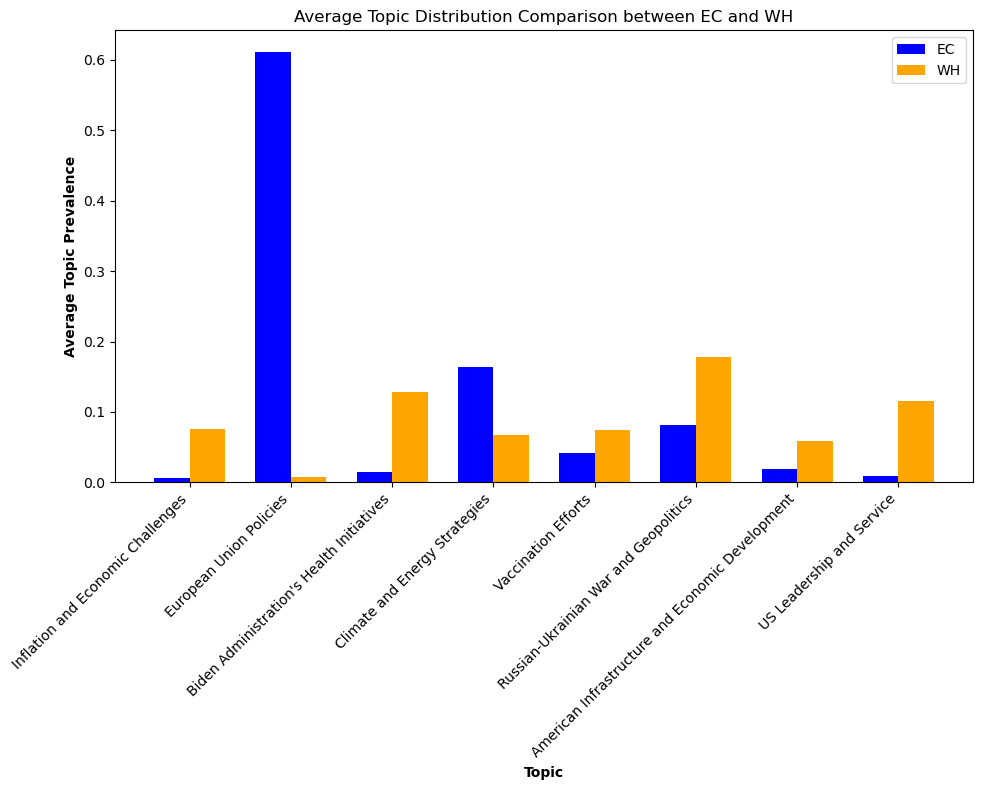

In [103]:
titles = [
    "Inflation and Economic Challenges", "Political Discourse", "European Union Policies",
    "American Discourse", "Biden Administration's Health Initiatives", "Climate and Energy Strategies",
    "Vaccination Efforts", "Russian-Ukrainian War and Geopolitics", 
    "American Infrastructure and Economic Development", "US Leadership and Service"
]

plt.figure(figsize=(10, 8))
bar_width = 0.35

# Filtered indices
filtered_indices = [i for i, title in enumerate(titles) if title not in ["Political Discourse", "American Discourse"]]

# Use filtered indices
r1 = np.arange(len(filtered_indices))
r2 = [x + bar_width for x in r1]

# Plotting with filtered data
plt.bar(r1, avg_topic_distribution_ec[filtered_indices], color='b', width=bar_width, label='EC')
plt.bar(r2, avg_topic_distribution_wh[filtered_indices], color='orange', width=bar_width, label='WH')

# Adding labels
plt.xlabel('Topic', fontweight='bold')
plt.ylabel('Average Topic Prevalence', fontweight='bold')

# Setting the x-tick labels with filtered titles, rotating them for better readability
plt.xticks([r + bar_width / 2 for r in range(len(filtered_indices))], [titles[i] for i in filtered_indices], rotation=45, ha='right')

# Creating legend & title
plt.legend()
plt.title('Average Topic Distribution Comparison between EC and WH')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [97]:
def aggregate_topic_shares(data, lda_model, corpus):
    # Get document topics
    doc_topics = [lda_model.get_document_topics(item, minimum_probability=0.0000001) for item in corpus]
    
    # Initialize topic columns in EC_data
    for topic_num in range(10):
        data[f'topic_{topic_num}'] = 0.0
    
    # Fill topic share in EC_data
    for i, doc_distribution in enumerate(doc_topics):
        for topic_num, prob in doc_distribution:
            data.at[i, f'topic_{topic_num}'] = prob
    
    # Calculate sum of topic shares and check if it's close to 1
    data['topic_sum'] = data[[f'topic_{i}' for i in range(10)]].sum(axis=1)
    data['sum_is_1'] = np.isclose(data['topic_sum'], 1.0)
    
    # Calculate words per topic
    data['length_in_words'] = data['text_preproc'].apply(lambda x: len(x.split()))
    for i in range(10):
        data[f'words_topic_{i}'] = data[f'topic_{i}'] * data['length_in_words']
    
    # Correctly convert the 'Date' column to 'year_month' format
    data['year_month'] = pd.to_datetime(data['Date']).dt.strftime('%Y-%m')
    aggregation_data = data[['year_month'] + [f'words_topic_{i}' for i in range(10)]]
    grouped_data = aggregation_data.groupby(['year_month']).sum().reset_index()
    
    # Adjust sums by alpha_prior and calculate topic shares
    alpha_prior = lda_model.alpha
    total_alpha_prior = sum(alpha_prior)
    for i in range(10):
        grouped_data[f'topic_share_{i}'] = (grouped_data[f'words_topic_{i}'] + alpha_prior[i]) / (grouped_data[[f'words_topic_{j}' for j in range(10)]].sum(axis=1) + total_alpha_prior)
    
    # Select final columns for the result DataFrame
    final_columns = ['year_month'] + [f'topic_share_{i}' for i in range(10)]
    result_df = grouped_data[final_columns]
    
    return result_df

joint_topic_shares = aggregate_topic_shares(joint_data, lda_model_joint, corpus_joint)

In [98]:
joint_topic_shares.head(5)
joint_topic_shares.set_index('year_month', inplace=True)



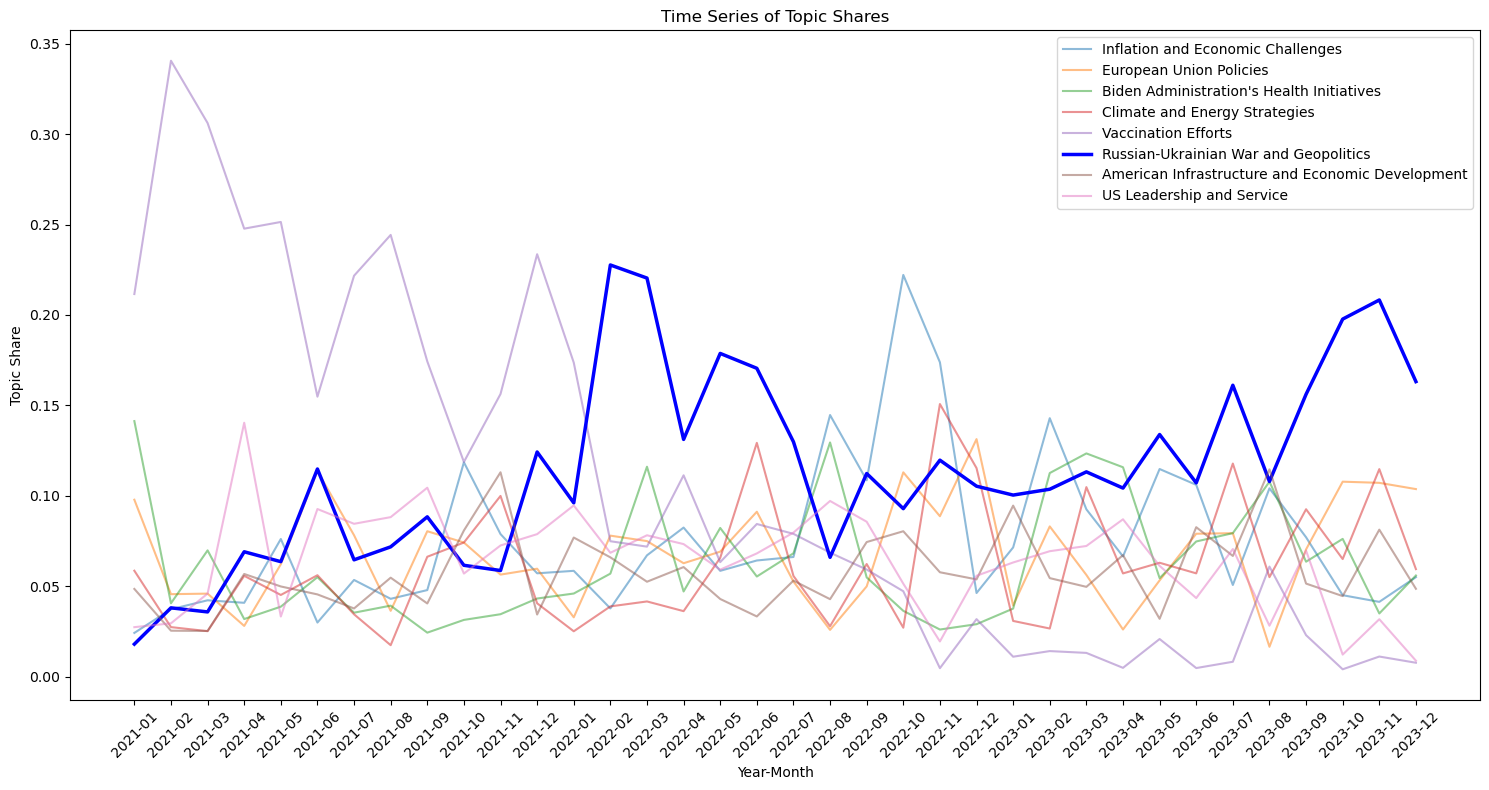

In [104]:
titles = [
    "Inflation and Economic Challenges", "Political Discourse", "European Union Policies",
    "American Discourse", "Biden Administration's Health Initiatives", "Climate and Energy Strategies",
    "Vaccination Efforts", "Russian-Ukrainian War and Geopolitics", 
    "American Infrastructure and Economic Development", "US Leadership and Service"
]

plt.figure(figsize=(15, 8))
for i, title in enumerate(titles):
    if title not in ["Political Discourse", "American Discourse"]:  # Excluding specific topics
        column = joint_topic_shares.columns[i]
        if title == "Russian-Ukrainian War and Geopolitics":  # Highlighting the topic related to Ukraine
            plt.plot(joint_topic_shares.index, joint_topic_shares[column], label=title, linewidth=2.5, linestyle='-', color='blue')
        else:
            plt.plot(joint_topic_shares.index, joint_topic_shares[column], label=title, linestyle='-', alpha=0.5) 

# Adding legend outside the plot, to the right
plt.legend(loc='upper right')

# Adding title and labels
plt.title('Time Series of Topic Shares')
plt.xlabel('Year-Month')
plt.ylabel('Topic Share')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

In [100]:
#Save the data into csv if needed to plot or do regressions
joint_topic_shares.to_csv('data/joint_topic_shares.csv')

# 4. Weekly contribution to each topic for each dataset 

In [102]:
# Convert the 'Date' column to datetime format
ec_data['year_week'] = pd.to_datetime(ec_data['Date']).dt.strftime('%Y-%U')
wh_data['year_week'] = pd.to_datetime(wh_data['Date']).dt.strftime('%Y-%U')

ec_data.head(5)
# Adjust the analysis function to analyze data by week
def analyze_data_by_week(data, cv, lda_model_joint):
    weekly_distributions = []
    for year_week, group in data.groupby('year_week'):
        vectorized_text = cv.transform(group.text_preproc).toarray()
        vectorized_title = cv.transform(group.titles_preproc).toarray()
        dtm = 2 * vectorized_title + vectorized_text
        dtm_sparse = csr_matrix(dtm)
        corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)
        topics = lda_model_joint.get_document_topics(corpus, minimum_probability=0)
        avg_topic_distribution = np.mean([[topic_prob for topic_id, topic_prob in doc] for doc in topics], axis=0)
        weekly_distributions.append((year_week, avg_topic_distribution))
    return weekly_distributions

# Run weekly analysis for EC and WH data
ec_weekly_distributions = analyze_data_by_week(ec_data, cv, lda_model_joint)
wh_weekly_distributions = analyze_data_by_week(wh_data, cv, lda_model_joint)

# Adjust the function to convert daily distributions to a DataFrame
def distributions_to_dataframe(distributions, prefix):
    # Convert distributions to a DataFrame
    columns = ['date'] + [f'{prefix}topic_{i}' for i in range(len(distributions[0][1]))]
    data = [{columns[0]: date, **{columns[i+1]: dist[i] for i in range(len(dist))}} 
            for date, dist in distributions]
    
    return pd.DataFrame(data, columns=columns)

# You can use the same 'distributions_to_dataframe' function for weekly data
# Just make sure to change the 'date' column label to 'year_week' or similar
ec_weekly_df = distributions_to_dataframe(ec_weekly_distributions, 'ec_')
wh_weekly_df = distributions_to_dataframe(wh_weekly_distributions, 'wh_')

# Merge the two DataFrames on 'year_week' to combine the weekly data
combined_weekly_df = ec_weekly_df.merge(wh_weekly_df, on='date')
# Save the combined DataFrame to a CSV file
combined_weekly_df.to_csv('combined_weekly_data.csv', index=False)

/var/folders/n4/wdz2gxc13wl6m46by5g242kh0000gn/T/ipykernel_15100/1115573715.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ec_data['year_week'] = pd.to_datetime(ec_data['Date']).dt.strftime('%Y-%U')
/var/folders/n4/wdz2gxc13wl6m46by5g242kh0000gn/T/ipykernel_15100/1115573715.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wh_data['year_week'] = pd.to_datetime(wh_data['Date']).dt.strftime('%Y-%U')


# 5. Appendix
Code that is not relevant for the final paper, but it was used for testing and exploration

## Monthly contributions

In [67]:
# ec_data['year_month'] = pd.to_datetime(ec_data['Date']).dt.strftime('%Y-%m')
# wh_data['year_month'] = pd.to_datetime(wh_data['Date']).dt.strftime('%Y-%m')

In [68]:
# def analyze_data_by_month(data, cv, lda_model_joint):
#     monthly_distributions = []
#     for year_month, group in data.groupby('year_month'):
#         vectorized_text = cv.transform(group.text_preproc).toarray()
#         vectorized_title = cv.transform(group.titles_preproc).toarray()
#         dtm = 2 * vectorized_title + vectorized_text
#         dtm_sparse = csr_matrix(dtm)
#         corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)
#         topics = lda_model_joint.get_document_topics(corpus, minimum_probability=0)
#         avg_topic_distribution = np.mean([[topic_prob for topic_id, topic_prob in doc] for doc in topics], axis=0)
#         monthly_distributions.append((year_month, avg_topic_distribution))
#     return monthly_distributions

# # Analyze EC data by month
# ec_monthly_distributions = analyze_data_by_month(ec_data, cv, lda_model_joint)
# #Analyzing WH data by month
# wh_monthly_distributions = analyze_data_by_month(wh_data, cv, lda_model_joint)


In [69]:
# def distributions_to_dataframe(distributions, prefix):
#     # Convert distributions to a DataFrame
#     columns = ['year_month'] + [f'{prefix}topic_{i}' for i in range(len(distributions[0][1]))]
#     data = [{columns[0]: year_month, **{columns[i+1]: dist[i] for i in range(len(dist))}} 
#             for year_month, dist in distributions]
    
#     return pd.DataFrame(data, columns=columns)

In [70]:
# # Transform distributions into DataFrames
# ec_df = distributions_to_dataframe(ec_monthly_distributions, 'ec_')
# wh_df = distributions_to_dataframe(wh_monthly_distributions, 'wh_')

# # Optionally, merge EC and WH DataFrames on year_month for a side-by-side comparison
# combined_df = ec_df.merge(wh_df, on='year_month')

# # Export to CSV
# ec_df.to_csv('data/ec_monthly_distributions.csv', index=False)
# wh_df.to_csv('data/wh_monthly_distributions.csv', index=False)
# combined_df.to_csv('data/combined_monthly_distributions.csv', index=False)

In [71]:
# combined_df.head(5)

In [72]:
# # Plotting ec_topic_5 vs wh_topic_5
# plt.figure(figsize=(10, 6))
# plt.plot(combined_df['year_month'], combined_df['ec_topic_5'], label='EC Topic 5', marker='o')
# plt.plot(combined_df['year_month'], combined_df['wh_topic_5'], label='WH Topic 5', marker='x')
# plt.title('EC vs WH Topic that mentions Ukraine Distribution Over Time')
# plt.xlabel('Year-Month')
# plt.ylabel('Topic Distribution')
# plt.xticks(rotation=45)
# plt.legend()
# plt.tight_layout()
# plt.show()

## Daily contributions

In [73]:
# # Convert the 'Date' column to string format
# ec_data['year_month_day'] = pd.to_datetime(ec_data['Date']).dt.strftime('%Y-%m-%d')
# wh_data['year_month_day'] = pd.to_datetime(wh_data['Date']).dt.strftime('%Y-%m-%d')

# # Adjust the analysis function to analyze data by day
# def analyze_data_by_day(data, cv, lda_model_joint):
#     daily_distributions = []
#     for year_month_day, group in data.groupby('year_month_day'):
#         vectorized_text = cv.transform(group.text_preproc).toarray()
#         vectorized_title = cv.transform(group.titles_preproc).toarray()
#         dtm = 2 * vectorized_title + vectorized_text
#         dtm_sparse = csr_matrix(dtm)
#         corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)
#         topics = lda_model_joint.get_document_topics(corpus, minimum_probability=0)
#         avg_topic_distribution = np.mean([[topic_prob for topic_id, topic_prob in doc] for doc in topics], axis=0)
#         daily_distributions.append((year_month_day, avg_topic_distribution))
#     return daily_distributions

# # Run daily analysis for EC and WH data
# ec_daily_distributions = analyze_data_by_day(ec_data, cv, lda_model_joint)
# wh_daily_distributions = analyze_data_by_day(wh_data, cv, lda_model_joint)

# # Convert daily distributions to DataFrames
# ec_daily_df = distributions_to_dataframe(ec_daily_distributions, 'ec_')
# wh_daily_df = distributions_to_dataframe(wh_daily_distributions, 'wh_')
# combined_daily_df = ec_daily_df.merge(wh_daily_df, on='date')


In [74]:
# # Export to CSV
# ec_daily_df.to_csv('data/ec_daily_distributions.csv', index=False)
# wh_daily_df.to_csv('data/wh_daily_distributions.csv', index=False)
# combined_daily_df.to_csv('data/combined_daily_distributions.csv', index=False)

In [75]:
# combined_daily_df.head(10)